In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def modmotor_ang(t_etapa, xant, accion, TL):
    Laa = 2.43309
    Ki = 0.411
    J = 0.00258956
    Km = 0.64803
    B = 0.0594551
    Ra = 2.43309

    Va = accion
    h = 1e-2

    omega = xant[0]
    wp = xant[1]
    theta = xant[2]
    ia = xant[3]

    for _ in range(int(t_etapa / h)):
        wpp = (-wp * (Ra * J + Laa * B) - omega * (Ra * B + Ki * Km) + Va * Ki) / (J * Laa)
        iap = (-Ra * ia - Km * omega + Va) / Laa

        wp = wp + h * wpp
        wp = wp - ((1 / J) * TL)

        omega = omega + h * wp
        ia = ia + h * iap
        theta = theta + h * omega

    return [omega, wp, theta, ia]


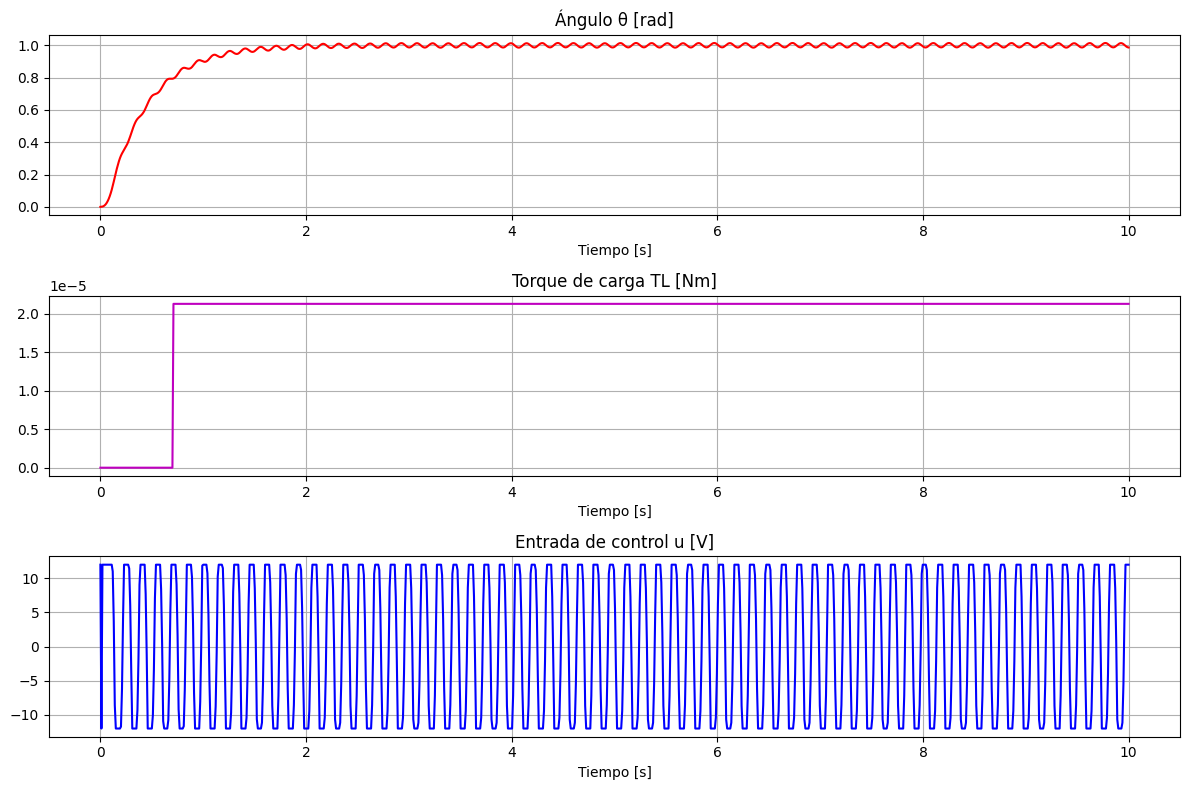

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Simulación
t_etapa = 1e-2
t_final = 10
N = int(t_final / t_etapa)

# PID sugerido por el enunciado
#Kp = 0.1
#Ki = 0.01
#Kd = 5
Kp = 2000
Ki = 5000
Kd = 10


Ts = t_etapa
A1 = ((2*Kp*Ts) + (Ki*(Ts**2)) + (2*Kd)) / (2*Ts)
B1 = ((-2*Kp*Ts) + (Ki*(Ts**2)) - (4*Kd)) / (2*Ts)
C1 = Kd / Ts

# Estado inicial del motor
X = [0, 0, 0, 0]

# Variables
theta_ref = 1
e = np.zeros(N+2)
u = 0
u_prev = 0

x1, x2, x3, x4, acc, carga = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

for k in range(N):
    tiempo = k * t_etapa

    # Torque externo (según figura 1-3)
    if tiempo >= 0.701:
        TL = 2.128e-5 
    else:
        TL = 0.0
    #if tiempo >= 1.001:
     #   TL = 0.0

    # Error actual
    e[k+2] = theta_ref - X[2]

    # PID discreto trapezoidal
    u = u_prev + A1*e[k+2] + B1*e[k+1] + C1*e[k]

    # Saturación
    u = max(min(u, 12), -12)
    u_prev = u

    # Simulación del modelo del motor
    X = modmotor_ang(t_etapa, X, u, TL)

    # Guardar datos
    x1[k] = X[0]
    x2[k] = X[1]
    x3[k] = X[2]
    x4[k] = X[3]
    acc[k] = u
    carga[k] = TL

# Gráficos
t = np.linspace(0, t_final, N)

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(t, x3, 'r')
plt.title('Ángulo θ [rad]')
plt.xlabel('Tiempo [s]')
plt.grid()

plt.subplot(3,1,2)
plt.plot(t, carga, 'm')
plt.title('Torque de carga TL [Nm]')
plt.xlabel('Tiempo [s]')
plt.grid()

plt.subplot(3,1,3)
plt.plot(t, acc, 'b')
plt.title('Entrada de control u [V]')
plt.xlabel('Tiempo [s]')
plt.grid()

plt.tight_layout()
plt.show()
